In [4]:
import joblib
import pandas as pd
import re
import numpy as np
import time
import os
import codecs
from collections import Counter

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize, sent_tokenize


from tqdm import tqdm
import json
import csv
from pprint import pprint
import matplotlib.pyplot as plt
import torch

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

#our functions
from fruitFlyVectorizer import FruitFlyVectorizer, clean
from model import KCnetwork

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


 # Fonctions de pré-traitement

In [5]:
def encode_word(word, vect_dictionnary):
    len_words=len(vect_dictionnary)
    vect_target= np.zeros(len_words, dtype=bool)
    vect_context= np.zeros(len_words, dtype=bool)
    if word in vect_dictionnary.keys():
        i=vect_dictionnary[word]
        vect_target[i]=True
    return torch.Tensor(np.hstack([vect_context,vect_target])).unsqueeze(0)
        

In [6]:
def encode_word_in_sentence(sentence,pos_target, vect_dictionnary):
    words= word_tokenize(sentence)
    target=words[pos_target:pos_target+1]
    context=words[:pos_target]+words[pos_target+1:]
    
    len_words=len(vect_dictionnary)
    vect_target= np.zeros(len_words, dtype=bool)
    vect_context= np.zeros(len_words, dtype=bool)
    
    for word in target:
        if word in vect_dictionnary.keys():
            i=vect_dictionnary[word]
            vect_target[i]=True
    for word in context:
        if word in vect_dictionnary.keys():
            i=vect_dictionnary[word]
            vect_context[i]=True
    return torch.Tensor(np.hstack([vect_context,vect_target])).unsqueeze(0)

# Récupération du modèle

In [7]:
vectorizer= joblib.load("./fruitFlyVectorizer_window=10.pkl")

In [8]:
W = torch.load("./weights_10_6380.pt")

In [9]:
W.shape

torch.Size([40000, 400])

In [10]:
dim_hidden = W.shape[1]
vocab_size = vectorizer.max_words
freq_words = torch.Tensor(list(vectorizer.freq_dictionnary.values()))
vect_dictionnary= vectorizer.vect_dictionnary

In [11]:
kcmodel = KCnetwork(dim_hidden, vocab_size, freq_words)


In [12]:
kcmodel.W = W
kcmodel = kcmodel.to("cpu")

In [13]:
## Test sur une phrase/

In [14]:
sentence = "I love foot ball and food and cinema and dancing or traveling because it's good for our health "

In [15]:
vect=encode_word_in_sentence(sentence,5, vect_dictionnary).to("cuda")

In [16]:
kcmodel.Hash(vect.to("cpu"),10).shape

torch.Size([1, 400])

# Expérimentations

## 1- Embeddings Similarity

In [15]:
# Datasets utilisé dans l'article et pré-traitements

In [16]:
class DatasetsWordSimilarity:
    def __init__(self, vect_dictionnary, model):
        self.datasets= {"men": None , "rg45":None, "mturk":None, 'rw':None, "wordsim":None, "simlex":None}
        self.loaded=False
        self.vect_dictionnary=vect_dictionnary
        self.model=model
        
    def list_datasets(self):
        return self.datasets.keys()#"{men, rg45, mturk, rw, wordsim, simlex}"
        
    def get_dataset(self, dataset):
        if dataset in self.datasets.keys():
            return self.datasets[dataset]
        else : return None
    
    def load(self ):
        self.datasets["men"]=pd.read_csv('datasets/embedding_similarity/men/MEN_dataset_natural_form_full', sep=" ")
        self.datasets["men"]["score"]=self.datasets["men"]["score"].apply(lambda x : x/50)
        
        self.datasets["rg45"]=pd.read_csv('datasets/embedding_similarity/rg45/rg45.txt', sep=";")
        self.datasets["rg45"]["score"]=self.datasets["rg45"]["score"].apply(lambda x : x/4)
        
    
        self.datasets["rw"]=pd.read_csv('datasets/embedding_similarity/rw/rw.txt', sep="\t")
        self.datasets["rw"]["score"]=self.datasets["rw"]["score"].apply(lambda x : x/10)
        
        self.datasets["wordsim"]=pd.read_csv('datasets/embedding_similarity/wordsim/wordsim.txt', sep="\t")
        self.datasets["wordsim"]["score"]=self.datasets["wordsim"]["score"].apply(lambda x : x/10)
        
        self.datasets["mturk"]=pd.read_csv('datasets/embedding_similarity/mturk/mturk.txt', sep="\t")
        self.datasets["mturk"]["score"]=self.datasets["mturk"]["score"].apply(lambda x : (x-1)/4)
        
        self.datasets["simlex"] = pd.read_csv('datasets/embedding_similarity/SIMLEX/SimLex-999.txt', sep="\t")
        self.datasets["simlex"]["score"]=self.datasets["simlex"]["score"].apply(lambda x : x/10)
        
        self.loaded=True
        return True
    
    
    def calcul_similarity(self, dataset, k):
        if self.loaded:
            if dataset in self.datasets.keys():
                data= self.datasets[dataset].copy()
                data['emb1']= data['word1'].apply(lambda x : self.model.Hash(encode_word(x, self.vect_dictionnary), k))
                data["emb2"]=data['word2'].apply(lambda x :self.model.Hash(encode_word(x, self.vect_dictionnary), k))
                #data['score_emb']= data[["emb1", "emb2"]].apply(lambda x:  print(x))
                f = lambda x, y : np.equal(x, y).sum()/len(x)
                data['score_emb']= data[["emb1", "emb2"]].apply(lambda x : f(x["emb1"], x["emb2"]), axis=1)
                self.datasets[dataset]["score_emb"]= data["score_emb"]
                res=stats.spearmanr(self.datasets[dataset]["score"].values, self.datasets[dataset]["score_emb"].values)[0]
                return res*100
            else :
                return -1
        else:
            print("Veuillez d'abord charger les datasets svp !!")
            return -1
            

In [17]:
 # Test de la classe

In [18]:
dataset= DatasetsWordSimilarity(vectorizer.vect_dictionnary , kcmodel)

In [19]:
dataset.list_datasets()

dict_keys(['men', 'rg45', 'mturk', 'rw', 'wordsim', 'simlex'])

In [20]:
dataset.load()

True

### Calcul des similarités pour chaque dataset
En utilisant la corrélation de spearman.

In [21]:
result = {}
for dataset_name in dataset.list_datasets():
    result[dataset_name] = dataset.calcul_similarity(dataset_name, 51)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


## 2- Clustering des Embeddings

In [26]:
# Nous allons tester différents algorithmes de clustering dont K-means et clustering Agglomératif.

In [42]:
class KmeansClustering():
    def __init__(self,model, vect_dictionnary, n_clusters):
        self.model = model
        self.words= list(vect_dictionnary.keys())
        self.vect_dictionnary= vect_dictionnary
        self.embeddings=None
        self.k=None
        self.n_clusters=n_clusters
        self.words_cluster=None
        
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0)))
        self.embeddings= embeddings
        return True
    
    def fit(self):
        self.clustering_model = KMeans(n_clusters=self.n_clusters, random_state=0, verbose=0).fit(self.embeddings)
        
    def predict(self, words):
        emb_words=[]
        for word in words: 
            emb_words.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),self.k).squeeze(0)))
        return self.clustering_model.predict(emb_words)
        
    def get_words_of_cluster(self, cluster):
        words=np.array(self.words)
        if np.any(self.words_cluster) == None:
            self.words_cluster= self.predict(self.words)
        return words[self.words_cluster==cluster]
    

In [43]:
class AggClustering():
    def __init__(self,model, vect_dictionnary, n_clusters):
        self.model = model
        self.words= list(vect_dictionnary.keys())
        self.vect_dictionnary= vect_dictionnary
        self.n_clusters = n_clusters
        self.embeddings=None
        self.k=None
        
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(list(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0)))
        self.embeddings= embeddings
        return True
    
    def fit(self):
        self.model = AgglomerativeClustering(n_clusters=self.n_clusters,affinity="cosine", linkage="average").fit(self.embeddings)
        
    
    def print_dendogram(self):
        fig, ax = plt.subplots(figsize=(20, 20))
        dend = hierarchy.dendrogram(
            hierarchy.linkage(self.embeddings, method="ward"),
            truncate_mode="lastp",
            metric='cosine',
            p=20,
            show_contracted=True,
        )
        fig.savefig("./datasets/sub_hierarchy.png", dpi=300)
        
    def get_words_of_cluster(self, cluster_id):
        words=np.array(self.words)
        return words[self.model.labels_==cluster_id]
    

#### Test Clustering Agglomératif

In [31]:
cluster = AggClustering(kcmodel, vectorizer.vect_dictionnary, 50)
cluster.get_embeddings(50)

True

In [32]:
cluster.fit()

In [33]:
res={}
for i in range(cluster.k):
    res[i] = len(cluster.get_words_of_cluster(i))

In [58]:
#Plot de la distribution du nombre d'éléments par cluster

In [ ]:
width = 2
plt.bar(res.keys(), res.values(), width, color='g')
plt.show()

In [ ]:
cluster.get_words_of_cluster(0)

#### Test Kmeans Clustering

In [44]:
cluster = KmeansClustering(kcmodel, vectorizer.vect_dictionnary, 50)
cluster.get_embeddings(50)

True

In [45]:
cluster.fit()

In [46]:
res={}
for i in range(cluster.k):
    res[i] = len(cluster.get_words_of_cluster(i))

In [47]:
#Plot de la distribution du nombre d'éléments par cluster

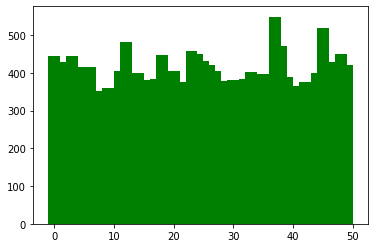

In [48]:
width = 2
plt.bar(res.keys(), res.values(), width, color='g')
plt.show()

In [58]:
cluster.get_words_of_cluster(0)

array(['long', 'look', 'everyone', 'attack', 'wednesday', 'seven',
       'allowed', 'written', 'dead', 'choice', 'capital', 'residents',
       'generally', 'lose', 'opened', 'ban', 'experts', 'eastern',
       'decide', 'closer', 'agencies', 'williams', 'youth', 'driven',
       'finance', 'golden', 'mine', 'bob', 'relevant', 'advertising',
       'stream', 'properly', 'universal', 'oct', 'basketball', 'keeps',
       'prize', 'everywhere', 'reviews', 'retired', 'mp', 'commander',
       'anybody', 'unemployment', 'advocates', 'vr', 'massachusetts',
       'speaks', 'legislative', 'submitted', 'shipping', 'bruce', 'rent',
       'smile', 'jets', 'artificial', 'centuries', 'requiring',
       'surprisingly', 'shocked', 'duke', 'di', 'removing', 'bands',
       'rangers', 'contents', 'painting', 'lens', 'backup', 'disabled',
       'wikipedia', 'residential', 'politician', 'mothers', 'roy',
       'mysterious', 'lobby', 'missiles', 'breakfast', 'layers',
       'departments', 'coordina

## 3-Contextual word embeddings

In [17]:
#Calcul des k plus proche voisin pour un mot en prenant en compte ou pas son contexte

In [18]:
from wordcloud import WordCloud
def plot_word_cloud(freq_dist):
    ''' Plot a word cloud visualisation to see most words used
    Args:
        freq_dist (array-like): Words distribution  get from nltk.FreqDist
    '''
    wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [19]:
class KNearestNeighbors():
    def __init__(self,model, vect_dictionnary):
        self.model=model
        self.vect_dictionnary=vect_dictionnary
        self.words=self.vect_dictionnary.keys()
        self.embeddings=None
        self.k=0
        
    
    def get_embeddings(self,k):
        self.k=k
        embeddings=[]
        for word in self.words:
            embeddings.append(self.model.Hash(encode_word(word, self.vect_dictionnary),k).squeeze(0))
        self.embeddings= embeddings
        return True
    
    
    def get_neighbors(self,sentence, pos_target, num_neighbors):
        vect= encode_word_in_sentence(sentence, pos_target, self.vect_dictionnary)
        dict_scores= {}
        for embedding,word in zip(self.embeddings, self.words):
            vect_word=self.model.Hash(vect.to("cpu"),self.k).squeeze(0)
            #print(vect_word.shape)
            calcul_similarite = lambda x, y : torch.eq(x, y).int().sum()*1.0/x.shape[0]
            dict_scores[word]= calcul_similarite(vect_word, embedding).item()
        dict_scores= sorted(dict_scores.items(), key=lambda x: x[1], reverse=True)
        list_best_scores= dict_scores[:num_neighbors]
        dict_scores={k:v for (k,v) in list_best_scores}
        return dict_scores
    
        

#### Affichage des plus proches voisins en WordCloud

In [20]:
nn=KNearestNeighbors(kcmodel, vectorizer.vect_dictionnary)

In [21]:
nn.get_embeddings(50)

True

In [22]:
# Test pour un mot

In [30]:
freq_dist=nn.get_neighbors("money in bank checking account",2,20)

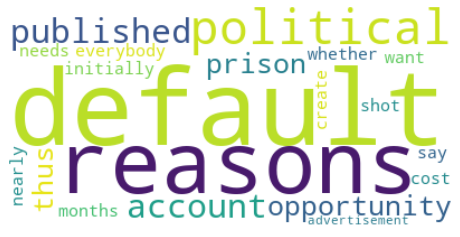

In [31]:
plot_word_cloud(freq_dist)

In [38]:
freq_dist=nn.get_neighbors("boat on the bank of the river",3,20)

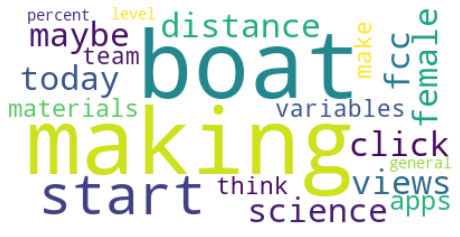

In [39]:
plot_word_cloud(freq_dist)

In [67]:
# Afficher les wordClouds pour 20 mots aléatoires.

In [37]:
#Liste des mots
words=np.array(list(vectorizer.freq_dictionnary.keys()))

In [38]:
sublist=np.random.choice(words,30)

WordCloud of word ==  critics


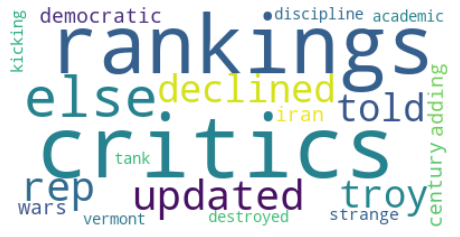

WordCloud of word ==  gravy


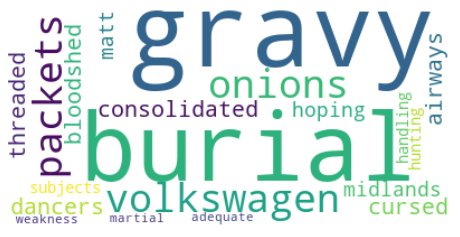

WordCloud of word ==  decisions


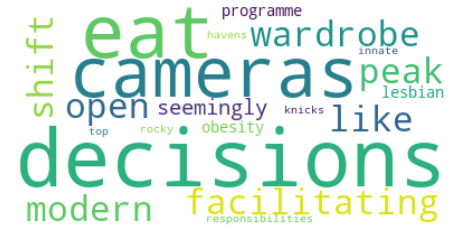

WordCloud of word ==  blew


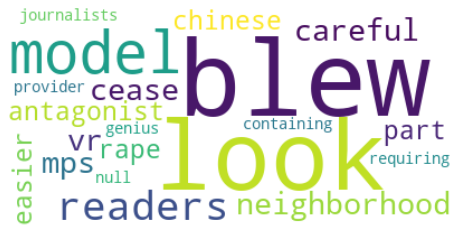

WordCloud of word ==  sixties


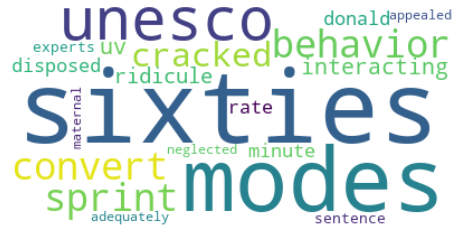

WordCloud of word ==  cancer


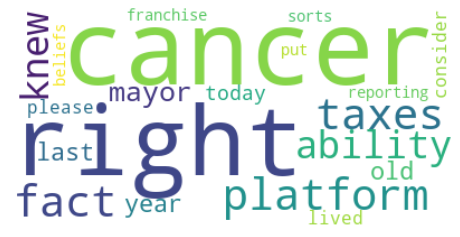

WordCloud of word ==  chevrolet


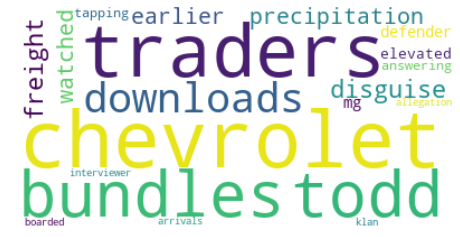

WordCloud of word ==  eager


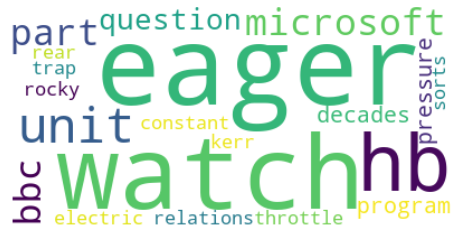

WordCloud of word ==  somewhere


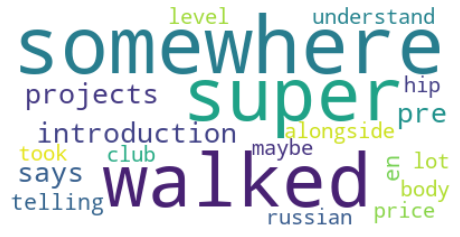

WordCloud of word ==  radically


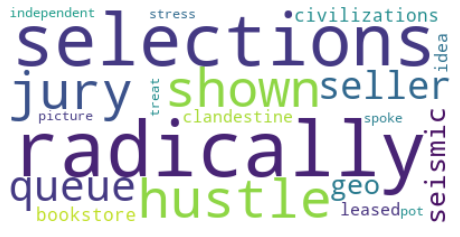

WordCloud of word ==  neil


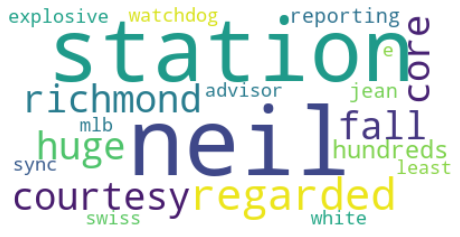

WordCloud of word ==  atrocities


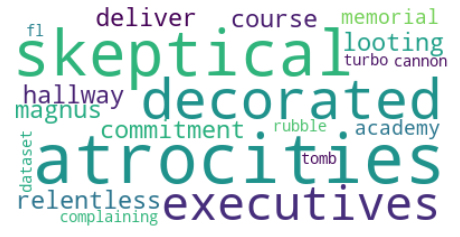

WordCloud of word ==  label


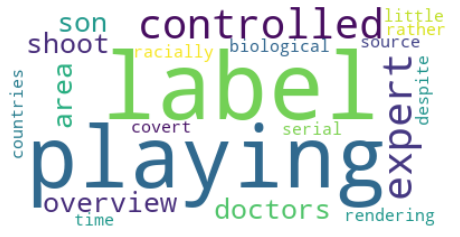

WordCloud of word ==  apart


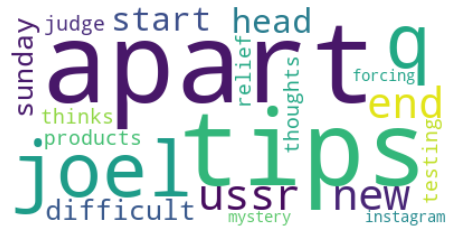

WordCloud of word ==  compartment


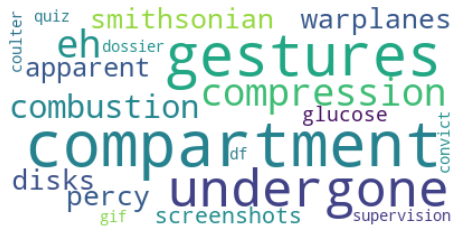

WordCloud of word ==  survivor


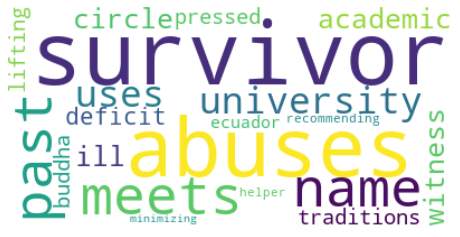

WordCloud of word ==  bogus


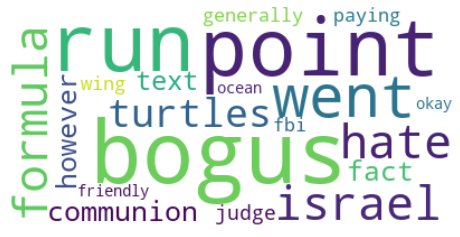

WordCloud of word ==  yorkshire


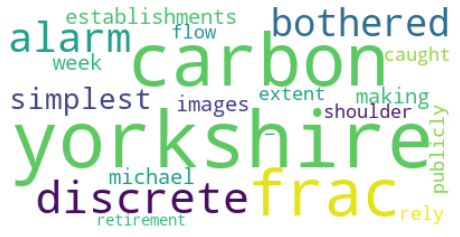

WordCloud of word ==  directional


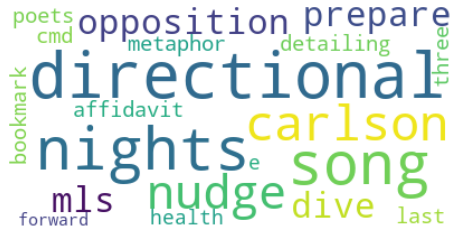

WordCloud of word ==  planner


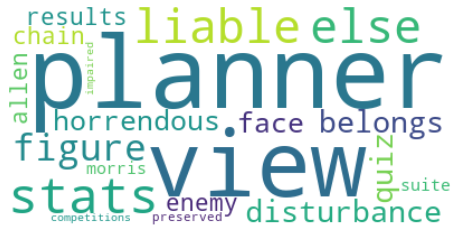

WordCloud of word ==  challenging


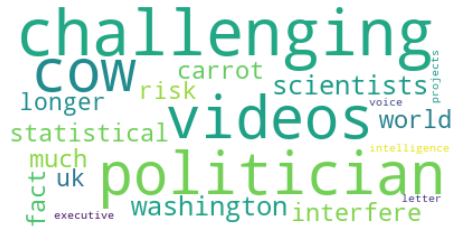

WordCloud of word ==  reliever


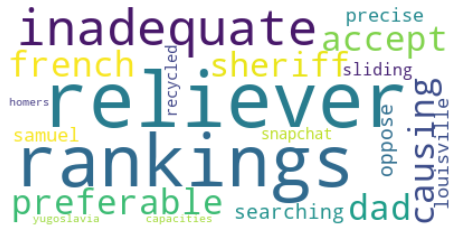

WordCloud of word ==  buckley


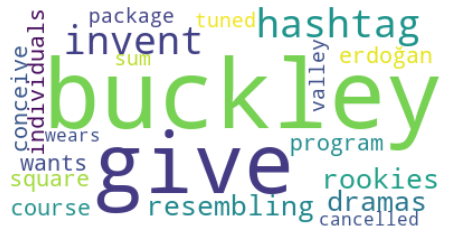

WordCloud of word ==  circumvent


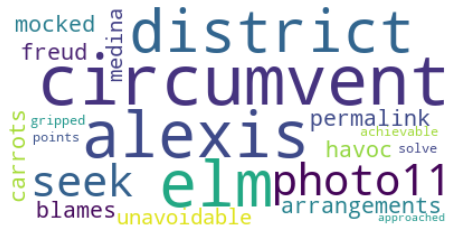

WordCloud of word ==  favorably


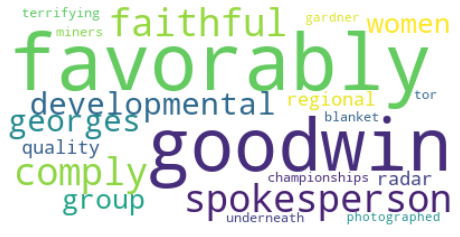

WordCloud of word ==  hover


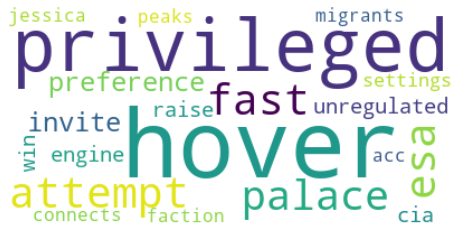

WordCloud of word ==  routinely


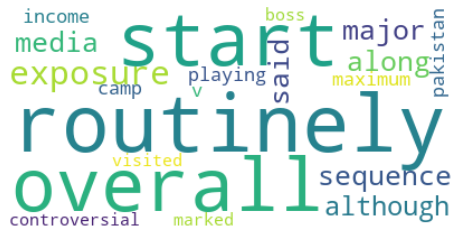

WordCloud of word ==  tossed


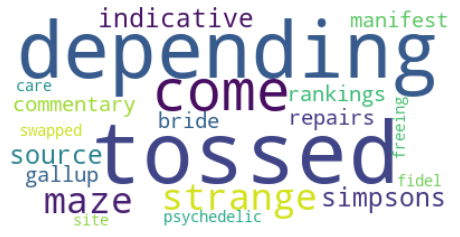

WordCloud of word ==  broken


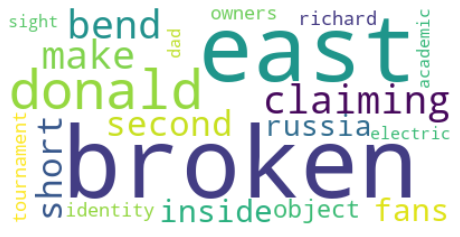

WordCloud of word ==  referring


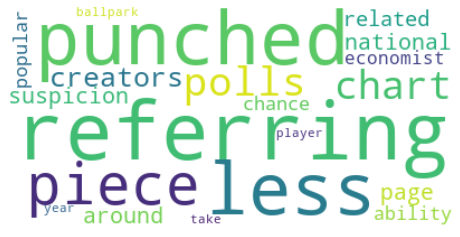

In [39]:
for word in sublist:
    freq_dist=nn.get_neighbors(word,0,20)
    print("WordCloud of word == ", word)
    plot_word_cloud(freq_dist)